In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

from torchvision.models.resnet import ResNet, BasicBlock
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
from tqdm import tqdm

import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()])
# mean and var of 3 channels

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)
# load 4 imgs at a time (4 imgs per batch)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
def plotImg(data,index):
    
    img,label= data[index]
    
    img = img.cpu().numpy()
    
    
    img = np.transpose(img, (1,2,0))[:,:,0]
    
    plt.imshow(img,cmap='gray')
    plt.title(str(int(label)))
    
    

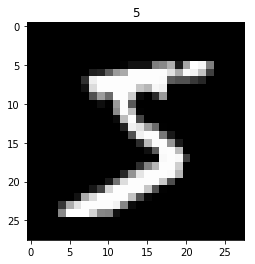

In [5]:
plotImg(trainset,0)

In [6]:
trainset[0][0].shape

torch.Size([1, 28, 28])

In [7]:
batch_size =64
mnist = torchvision.datasets.MNIST(download=True, train=True, root=".").train_data.float()

data_transform = Compose([ Resize((224, 224)),ToTensor(), Normalize((mnist.mean()/255,), (mnist.std()/255,))])

trainData = torchvision.datasets.MNIST(download=True, root=".", transform=data_transform, train=True)
testData = torchvision.datasets.MNIST(download=True, root=".", transform=data_transform, train=False)

trainloader = DataLoader(trainData,batch_size=batch_size, shuffle=True)

testloader = DataLoader(testData,
                        batch_size=batch_size, shuffle=False)


### Defining Model

In [8]:
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(
            super(MnistResNet, self).forward(x), dim=-1)

In [9]:
model = MnistResNet()

### Training

In [12]:
# params you need to specify:

train_loader, val_loader = trainloader, testloader
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, I've used Adadelta, as it wokrs well without any magic numbers
optimizer = optim.Adadelta(model.parameters())

model.to(device)

start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [14]:
epochs = 2

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))


Loss: 1.4700: 100%|██████████| 938/938 [02:17<00:00,  6.83it/s]

In [15]:
# torch.save(model.state_dict(),'MNIST_Resnet_model')

In [19]:
def calculate_metric(metric_fn, true_y, pred_y):
    # multi class problems need to have averaging method
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    # just an utility printing function
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [20]:
val_losses = 0
precision, recall, f1, accuracy = [], [], [], []
    
model.eval()
with torch.no_grad():
    for i, data in enumerate(val_loader):
        X, y = data[0].to(device), data[1].to(device)

        outputs = model(X) # this get's the prediction from the network

        val_losses += loss_function(outputs, y)

        predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction

        # calculate P/R/F1/A metrics for batch
        for acc, metric in zip((precision, recall, f1, accuracy), 
                               (precision_score, recall_score, f1_score, accuracy_score)):
            acc.append(
                calculate_metric(metric, y.cpu(), predicted_classes.cpu())
            )

print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
print_scores(precision, recall, f1, accuracy, val_batches)
losses.append(total_loss/batches)

Epoch 2/2, training loss: 1.470023209860584, validation loss: 1.4736971855163574
	     precision: 0.9879
	        recall: 0.9878
	            F1: 0.9864
	      accuracy: 0.9877


In [22]:
model.modules

<bound method Module.modules of MnistResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (r

### Extracting Features

In [10]:
model.load_state_dict(torch.load('MNIST_Resnet_model'))
model.cuda()

my_embedding = 0

def copyData(m, inp, out):
    global my_embedding
    out1 = out.detach().cpu().numpy()[:,:,0,0]
    my_embedding = out1

#Registering a forward hook
hook = model.avgpool.register_forward_hook(copyData)

In [11]:
model.eval()
featList = []
labelList = []

with torch.no_grad():
    for i in tqdm(range(len(testData))):
    
        img, label = testData[i]
        img = img.cuda().unsqueeze(0)
        label = int(label)
        
        out = model(img)
        
        featList.append(my_embedding.copy())
        labelList.append(label)

  4%|▍         | 441/10000 [00:01<00:23, 399.48it/s]


KeyboardInterrupt: 

In [12]:
# testBucket =(testData, featList)
# pickle.dump(testBucket,open('testBucket','wb'))


In [12]:
a = pickle.load(open('testBucket','rb'))
(testData,featList) = a

### Understanding Features

In [21]:
# featList = [x[0] for x in featList]

# df = pd.DataFrame(np.array(featList))

# df['label'] = labelList

# # df.to_csv('df_model1.csv',index=False,index_label=False)

In [17]:
df = pd.read_csv('df_model1.csv')
df.columns = list(range(0,512))+['label']

In [18]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,1.516339,0.872603,0.634782,1.006270,0.748797,0.573148,0.157342,0.726397,0.740587,0.007760,...,0.734867,0.274438,0.728074,0.683716,1.673455,0.984131,0.736623,0.483956,0.089134,7
1,1.161490,0.410824,1.485814,1.095896,0.182317,0.122844,0.666845,2.484679,0.552345,1.438394,...,2.813763,2.431349,0.373654,1.141933,0.093373,1.326844,1.696899,0.373479,1.737158,2
2,0.319324,0.011092,1.658930,0.009037,0.212234,1.741956,0.423228,0.834735,0.064467,0.025303,...,0.047774,0.077275,0.699473,0.227915,0.553338,0.576975,0.284270,0.107740,0.268365,1
3,0.625836,1.378313,0.283449,1.360308,0.723668,0.119075,0.298919,1.298518,0.313413,1.608733,...,1.012810,1.503490,0.421001,0.430285,1.268622,0.482462,0.623761,0.654304,0.265884,0
4,0.042843,0.026150,2.391388,0.104869,1.082385,0.182814,0.618181,0.451976,0.105300,0.234857,...,0.945233,1.487976,3.146891,0.368749,0.579819,2.370322,0.772304,0.885889,0.403120,4


In [20]:
def getTopFeatures(df,label):
    sub = df[df.label==label]
    
    meanDf = pd.Series(np.mean(sub.iloc[:,0:512])).reset_index()

    meanDf = meanDf.sort_values(0,ascending=False)
    
    return meanDf

def plotFeature(data, df, featureIndex, n =10):
    
    try:
        df = df.sort_values(featureIndex, ascending = False)[:n].reset_index()
    except:
        df = df.sort_values(str(featureIndex), ascending = False)[:n].reset_index()
        
        
    df = df.rename({"index":"position"},axis =1)
    
    numCols = 5
    numRows = n//numCols if n%numCols==0 else (n//numCols + 1)
    
    plt.figure(figsize = (10,5))
    for i in range(n):
    
        
        sample_index = int(df.iloc[i]['position'])
        
        img, label = data[sample_index]
        img = img.cpu().numpy()
        img = np.transpose(img, (1,2,0))[:,:,0]
        
        plt.subplot(numRows,numCols,i+1)
        plt.imshow(img)
        plt.title(str(int(label))+"_"+str(sample_index))
    
def getCorrPairs(df, index):
    
    outList = []
    
    for i in range(len(index)-1):
        for j in range(i+1, len(index)):
            
            corr = np.corrcoef(df.loc[:,[index[i],index[j]]].T)[0][1]
            outList.append([index[i],index[j],corr])
            
    out = pd.DataFrame(outList)
    out.columns = ['feat1','feat2','corr']
    
    return out
            
                

In [282]:
result =getTopFeatures(df,4)
result.head(15)

,index,0
505,505,3.035875
397,397,2.883807
355,355,2.765825
500,500,2.681365
187,187,2.653908
19,19,2.632719
254,254,2.610242
176,176,2.558966
380,380,2.551874
335,335,2.525462


In [283]:
df.sort_values(505,ascending=False).head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
7066,0.162248,0.025652,1.942057,0.208002,0.930424,0.122508,0.257705,0.472308,0.155824,0.317281,...,1.384869,1.812523,4.313682,0.538817,0.921059,3.652620,0.940306,0.514881,0.510302,4
5500,0.143525,0.043587,2.208920,0.205853,0.837166,0.063400,0.345621,0.948707,0.090930,0.509716,...,1.746927,2.598482,4.313593,0.782189,0.869095,3.732495,1.191252,0.405592,0.722303,4
7092,0.119331,0.016500,2.377838,0.176137,0.930017,0.047026,0.283129,0.644113,0.086136,0.280208,...,1.662794,2.343477,4.242023,0.645410,0.952798,3.598370,1.174855,0.510776,0.441393,4
8743,0.108514,0.029174,2.097809,0.212626,0.925222,0.107151,0.320643,0.479251,0.148274,0.350408,...,1.321372,1.989715,4.198943,0.667993,0.893860,3.609941,1.044921,0.588946,0.507902,4
7096,0.162938,0.012350,2.309876,0.162767,0.822638,0.076651,0.273787,0.560633,0.105303,0.225630,...,1.409936,1.985820,4.175377,0.577368,0.921915,3.502433,1.000032,0.447393,0.408537,4


In [47]:
d = df.sort_values(509,ascending=False).iloc[:5].reset_index()

In [49]:
d = d.rename({"index":"position"},axis =1)

d.head()

,position,0,1,2,3,4,5,6,7,8,...,503,504,505,506,507,508,509,510,511,label
0,9707,0.516385,1.286429,1.530604,0.696816,2.053761,0.529774,2.267500,0.757976,0.742154,...,0.848287,2.012888,0.329704,0.740861,0.179965,0.222054,3.359907,2.699457,0.487491,3
1,1489,0.506317,1.228266,1.504095,0.848913,2.046487,0.417914,1.652499,0.734459,0.596607,...,0.841596,2.405420,0.427630,0.826449,0.257320,0.135791,3.350598,2.300644,0.358350,3
2,648,0.585162,1.331039,1.544038,0.886078,2.235614,0.452919,1.907781,0.681831,0.673849,...,0.703214,2.302077,0.383725,0.855594,0.188182,0.152696,3.321755,2.454163,0.438867,3
3,801,0.459894,0.910427,1.758203,0.678902,1.590865,0.442561,1.611026,0.824128,0.534436,...,1.275722,2.468700,0.616492,0.704574,0.359350,0.109533,3.317132,1.964900,0.466149,3
4,8026,0.418719,1.532788,1.909997,0.741617,2.237181,0.489602,1.806533,0.722828,0.638394,...,0.664655,2.269001,0.194725,0.301900,0.158995,0.211484,3.311700,2.820683,0.310390,3


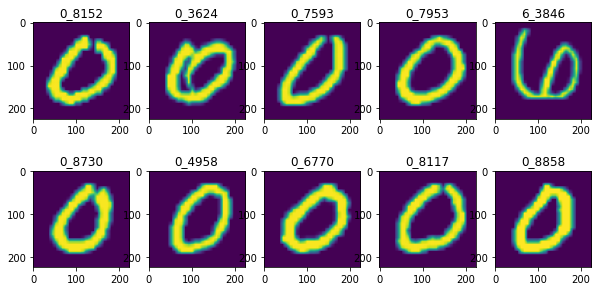

In [104]:
plotFeature(testData, df,501)

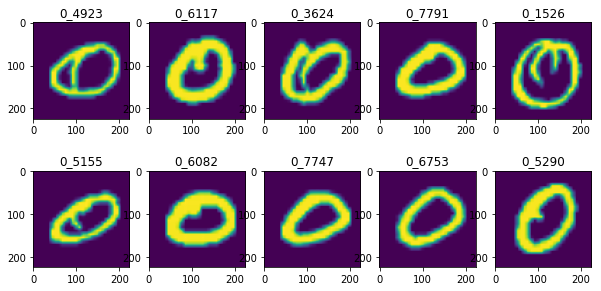

In [105]:
plotFeature(testData, df,314)



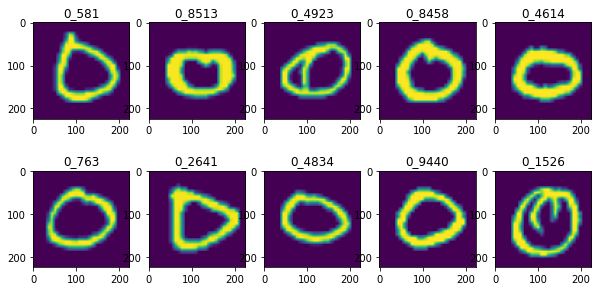

In [106]:
plotFeature(testData, df,448)

In [84]:
np.corrcoef(df.loc[:,[448,314,501]].T)

array([[1.        , 0.71535157, 0.69709638],
       [0.71535157, 1.        , 0.76781869],
       [0.69709638, 0.76781869, 1.        ]])

In [82]:
df.loc[:,[448,314,501]].

,448,314,501
0,0.687322,0.111755,0.237770
1,1.389846,0.992495,0.716099
2,0.064049,0.076675,0.462865
3,2.329551,2.287011,2.475346
4,0.687141,0.598600,1.750633
5,0.075287,0.169461,0.447938
6,0.573220,0.540019,1.639065
7,0.662955,0.823961,0.629140
8,1.543000,0.565225,0.790714
9,0.254733,0.481926,0.799146


In [288]:
result.index.values[:10]

array([505, 397, 355, 500, 187,  19, 254, 176, 380, 335])

In [287]:
print(np.corrcoef(df.loc[:,result.index.values[:10]].T))

[[1.         0.88767417 0.9323414  0.83035311 0.63459819 0.8440467
  0.85626185 0.74055039 0.81516813 0.77677581]
 [0.88767417 1.         0.85876505 0.81876086 0.88001804 0.6413037
  0.83238469 0.86169007 0.65418211 0.84004657]
 [0.9323414  0.85876505 1.         0.84425055 0.54819592 0.81501636
  0.75941322 0.6287493  0.8667556  0.63346239]
 [0.83035311 0.81876086 0.84425055 1.         0.61720668 0.78395135
  0.80954304 0.57445646 0.86203984 0.60727236]
 [0.63459819 0.88001804 0.54819592 0.61720668 1.         0.36602095
  0.6347537  0.88306979 0.30656363 0.75350006]
 [0.8440467  0.6413037  0.81501636 0.78395135 0.36602095 1.
  0.6561787  0.48787035 0.81633985 0.43544943]
 [0.85626185 0.83238469 0.75941322 0.80954304 0.6347537  0.6561787
  1.         0.63330215 0.75999371 0.85130606]
 [0.74055039 0.86169007 0.6287493  0.57445646 0.88306979 0.48787035
  0.63330215 1.         0.39090493 0.80852171]
 [0.81516813 0.65418211 0.8667556  0.86203984 0.30656363 0.81633985
  0.75999371 0.39090493

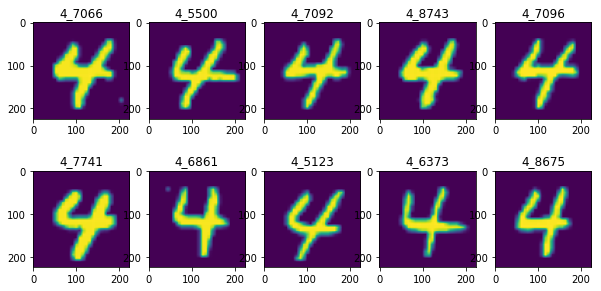

In [284]:
plotFeature(testData, df,505)

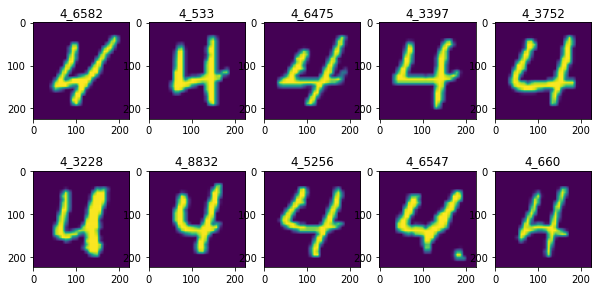

In [289]:
plotFeature(testData, df,187)

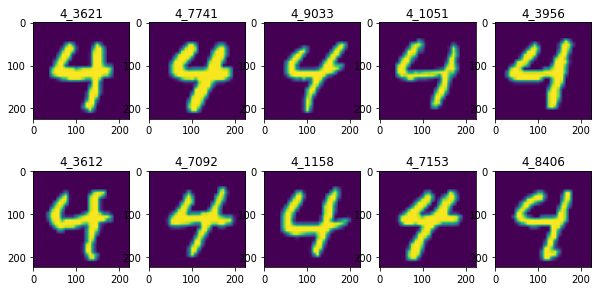

In [290]:
plotFeature(testData, df,380)

### Occlusion Testing

In [47]:
def plotOccFeat(occFeatList, index):
    featureVec = occFeatList[:,index]
    plt.imshow(featureVec.reshape(224,224),cmap='gray')
    
    
def getFeatLabelProb(df, feature,n):
    
    df = df.sort_values(feature, ascending=False)[:n]
    
    return df.label.value_counts()

# torch and torchvision imports

class OcclusionDataset(torch.utils.data.Dataset):
  def __init__(self, img,size=5):
    
    
    if img.shape[0]==1:
        img = np.transpose(img, (1,2,0))
    self.img = img
    
    self.size = size
    self.h, self.w = img.shape[0],img.shape[1]
    
  def __len__(self):
    
    return (self.w * self.h)
    
  def __getitem__(self, index):
    
    col = index%self.w
    row = index//self.w
    
    s = self.size//2

    out = self.img.copy()
    out[(row - s):(row+s), (col-s):(col+s),:]= -0.4240  #since in the normalized data, 0 is represented by -0.424

    
    out = transforms.ToTensor()(out)
   
    return out, (row)


def getOccFeatList(data, index, size = 50):


    occData = OcclusionDataset(data[index][0].cpu().numpy(), size =size)
    occLoader = DataLoader(occData, shuffle=False, batch_size=300)
    
    occFeatList = []
    posList = []

    with torch.no_grad():
        for i in tqdm(occLoader):

            sample, pos = i

            out = model(sample.cuda())

            occFeatList.append(my_embedding.copy())

            posList.append(pos)

    occFeatList = np.concatenate(occFeatList,axis=0)  
    
    return occFeatList
    
    

In [303]:
sampleID = 7092

occData = OcclusionDataset(testData[sampleID][0].cpu().numpy(), size =50)

occLoader = DataLoader(occData, shuffle=False, batch_size=300)

occFeatList = []
posList = []

with torch.no_grad():
    for i in tqdm(occLoader):

        sample, pos = i

        out = model(sample.cuda())

        occFeatList.append(my_embedding.copy())

        posList.append(pos)
        
occFeatList = np.concatenate(occFeatList,axis=0)        

In [246]:
feature_index = 501

In [247]:
featureVec = occFeatList[:,feature_index]

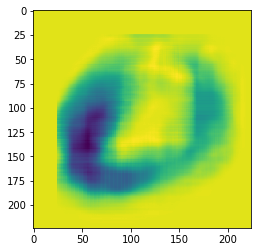

In [249]:
plotOccFeat(occFeatList,501)

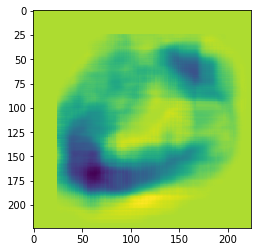

In [250]:
featureVec = occFeatList[:,448]
plt.imshow(featureVec.reshape(224,224))

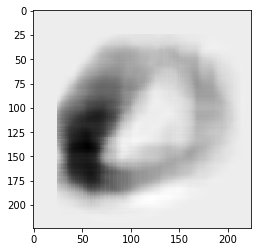

In [255]:
featureVec = occFeatList[:,314]
plt.imshow(featureVec.reshape(224,224),cmap='gray')

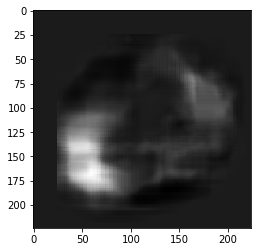

In [256]:
featureVec = occFeatList[:,319]
plt.imshow(featureVec.reshape(224,224),cmap='gray')

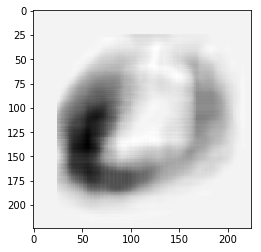

In [265]:
plotOccFeat(occFeatList, 501)

In [270]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,1.516340,0.872603,0.634782,1.006270,0.748797,0.573148,0.157342,0.726397,0.740587,0.007760,...,0.734867,0.274438,0.728074,0.683716,1.673455,0.984131,0.736623,0.483956,0.089134,7
1,1.161490,0.410824,1.485814,1.095896,0.182317,0.122844,0.666845,2.484679,0.552345,1.438394,...,2.813763,2.431349,0.373654,1.141933,0.093373,1.326844,1.696899,0.373479,1.737158,2
2,0.319324,0.011092,1.658930,0.009037,0.212234,1.741956,0.423228,0.834735,0.064467,0.025303,...,0.047774,0.077275,0.699472,0.227915,0.553338,0.576975,0.284270,0.107740,0.268365,1
3,0.625836,1.378313,0.283449,1.360308,0.723668,0.119075,0.298919,1.298518,0.313413,1.608733,...,1.012810,1.503490,0.421001,0.430286,1.268622,0.482462,0.623761,0.654304,0.265884,0
4,0.042843,0.026150,2.391388,0.104869,1.082385,0.182814,0.618181,0.451976,0.105300,0.234857,...,0.945233,1.487976,3.146891,0.368749,0.579818,2.370322,0.772304,0.885889,0.403120,4


In [271]:
getFeatLabelProb(df,501,100)

0    99
6     1
Name: label, dtype: int64

In [272]:
getFeatLabelProb(df,319,100)

7    100
Name: label, dtype: int64

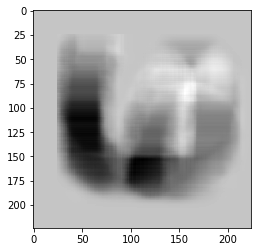

In [276]:
plotOccFeat(occFeatList,501)

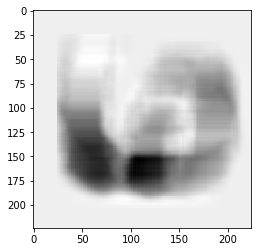

In [277]:
plotOccFeat(occFeatList,448)

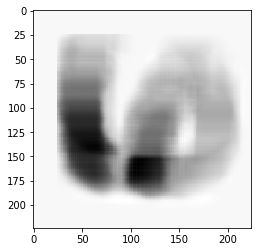

In [278]:
plotOccFeat(occFeatList,314)

## Digit 4

#### sample 3621

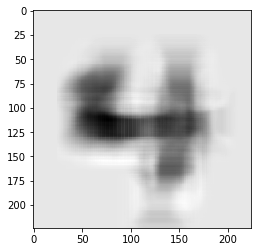

In [294]:
plotOccFeat(occFeatList,380)

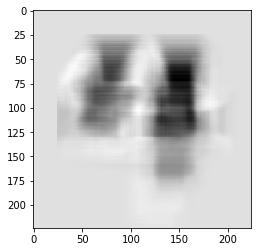

In [295]:
plotOccFeat(occFeatList,187)

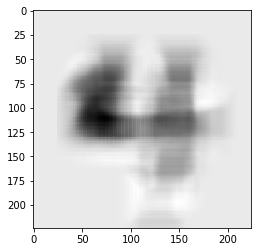

In [296]:
plotOccFeat(occFeatList,505)

#### sample 6475

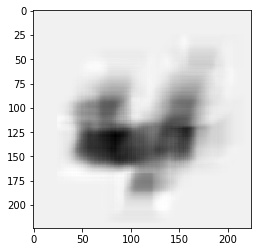

In [300]:
plotOccFeat(occFeatList,380)

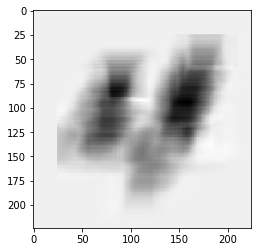

In [301]:
plotOccFeat(occFeatList,187)

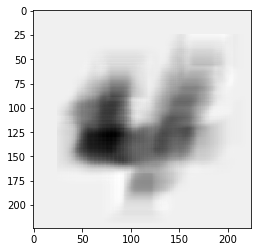

In [302]:
plotOccFeat(occFeatList,505)

#### sample 7092

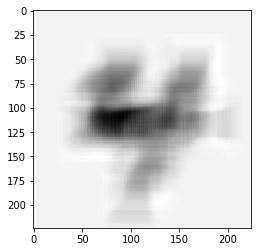

In [306]:
plotOccFeat(occFeatList,380)

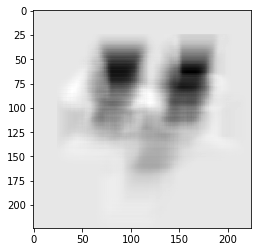

In [307]:
plotOccFeat(occFeatList,187)

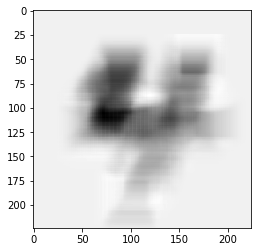

In [308]:
plotOccFeat(occFeatList,505)

## Digit 6

In [21]:
result =getTopFeatures(df,6)
result.head(15)

,index,0
201,201,2.943290
169,169,2.864032
189,189,2.852962
214,214,2.695360
449,449,2.638453
451,451,2.534908
210,210,2.518738
135,135,2.497810
283,283,2.475266
385,385,2.442903


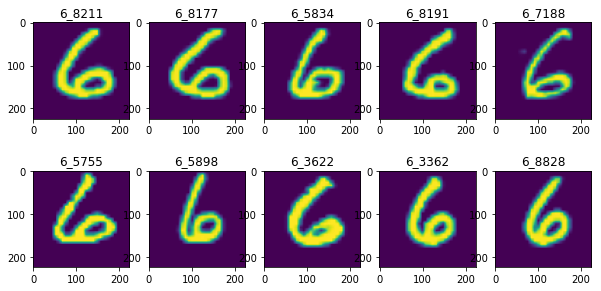

In [22]:
plotFeature(testData, df,201)

In [33]:
corrOut = getCorrPairs(df,result.index.values[:15])

In [34]:
corrOut.sort_values('corr')

,feat1,feat2,corr
79,135,59,0.350156
9,201,59,0.380189
77,135,283,0.454490
90,385,59,0.463007
95,59,25,0.506618
42,214,135,0.517391
7,201,283,0.523412
71,210,385,0.533492
44,214,385,0.534462
73,210,25,0.545351


#### Sample 8211

In [38]:
occFeatList = getOccFeatList(testData,8211)

100%|██████████| 168/168 [00:29<00:00,  5.70it/s]


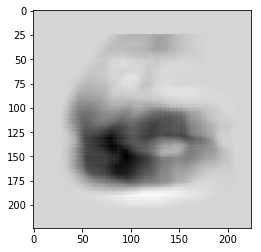

In [39]:
plotOccFeat(occFeatList,201)

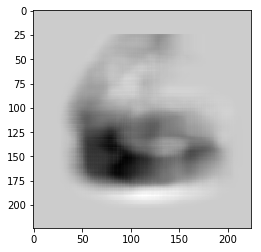

In [41]:
plotOccFeat(occFeatList,135)

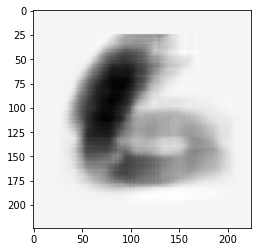

In [42]:
plotOccFeat(occFeatList,59)

#### Sample 3622

In [43]:
occFeatList = getOccFeatList(testData,3622)

100%|██████████| 168/168 [00:29<00:00,  5.69it/s]


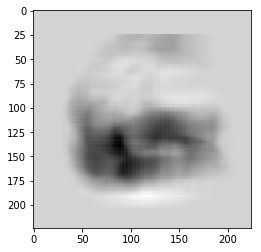

In [44]:
plotOccFeat(occFeatList,201)

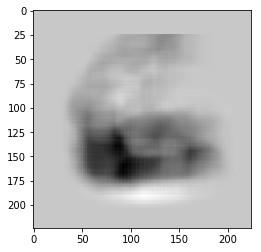

In [45]:
plotOccFeat(occFeatList,135)

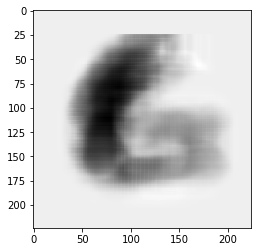

In [46]:
plotOccFeat(occFeatList,59)

In [56]:
occFeatList = getOccFeatList(testData,3622,size=20)

100%|██████████| 168/168 [00:29<00:00,  5.62it/s]


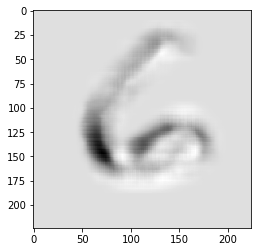

In [57]:
plotOccFeat(occFeatList,201)

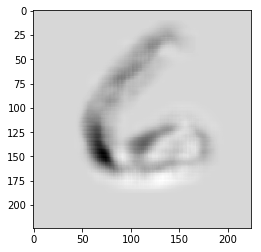

In [58]:
plotOccFeat(occFeatList,135)

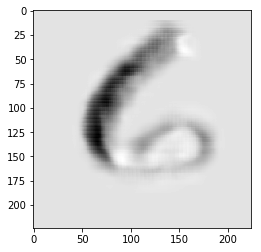

In [59]:
plotOccFeat(occFeatList,59)

In [166]:
occFeatList = [x[0] for x in occFeatList]

occFeatList = np.array(occFeatList)

In [170]:
featVector = occFeatList[:,501]

In [177]:
len(featVector)

30625

In [190]:
h = np.max([x[0] for x in posList])

In [191]:
h

176

In [192]:
np.max([x[1] for x in posList])

173

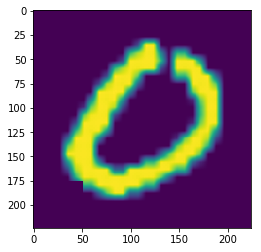

In [193]:
plt.imshow(occData[30625][0].numpy().transpose(1,2,0)[:,:,0])

In [179]:
(224-50+1)*(224-50+1)

30625

In [180]:
occData[30625][1]

(136, 161)

In [181]:
136+50

186

In [182]:
161+50

211

In [202]:
occData[(224-50)*175 - 1][1]

(174, 173)

In [203]:
173+50

223

In [204]:
176+50

226

In [213]:
q=next(iter(occLoader))

In [218]:
q[0].shape

torch.Size([100, 1, 224, 224])

In [220]:
out = model(q[0].cuda())

In [221]:
my_embedding.shape

(100, 512)

In [222]:
my_embedding[0]

array([5.9918416e-01, 1.4620322e+00, 3.4791350e-01, 1.5056106e+00,
       9.0669131e-01, 9.4947942e-02, 6.9607802e-02, 1.6593924e+00,
       2.7839682e-01, 1.9863652e+00, 2.0972292e+00, 1.7341469e-01,
       2.6394122e+00, 3.7650973e-01, 1.3098155e-01, 1.7089677e+00,
       2.6461485e-01, 5.5928010e-02, 1.4290249e-01, 8.0480123e-01,
       1.9442585e+00, 2.3293364e-01, 7.6725893e-02, 3.7841666e-01,
       1.1614333e+00, 7.6070726e-01, 2.1086020e+00, 3.0838516e-01,
       1.9665234e+00, 1.5193253e+00, 8.1954771e-01, 7.1482295e-01,
       1.4903520e+00, 1.8216172e-01, 3.6877477e-01, 4.5414381e-02,
       4.0008202e-01, 1.3659063e-01, 2.6695064e-01, 5.5061466e-01,
       3.4992498e-01, 8.5010983e-02, 4.0657058e-01, 1.7716140e+00,
       2.0262532e+00, 1.6505172e+00, 1.1889548e+00, 1.7014862e+00,
       2.2472043e+00, 5.8557761e-01, 1.5025181e-01, 1.1754724e+00,
       1.1538543e+00, 7.6197642e-01, 6.6476917e-01, 6.6951400e-01,
       5.0396603e-01, 5.3726721e-01, 2.5086457e-01, 1.1227925e

In [209]:
sampleFeat = occFeatList[0]

In [210]:
sampleFeat

array([[5.99182844e-01, 1.46203113e+00, 3.47917348e-01, 1.50560927e+00,
        9.06692326e-01, 9.49472114e-02, 6.96076527e-02, 1.65939164e+00,
        2.78396517e-01, 1.98636532e+00, 2.09722948e+00, 1.73414752e-01,
        2.63941431e+00, 3.76510143e-01, 1.30981520e-01, 1.70896852e+00,
        2.64614791e-01, 5.59280440e-02, 1.42901286e-01, 8.04802477e-01,
        1.94425607e+00, 2.32933357e-01, 7.67257810e-02, 3.78414631e-01,
        1.16143334e+00, 7.60704875e-01, 2.10860252e+00, 3.08385193e-01,
        1.96652424e+00, 1.51932335e+00, 8.19546580e-01, 7.14823604e-01,
        1.49035192e+00, 1.82161704e-01, 3.68776202e-01, 4.54143807e-02,
        4.00081784e-01, 1.36590898e-01, 2.66952366e-01, 5.50615013e-01,
        3.49925756e-01, 8.50112513e-02, 4.06569839e-01, 1.77161419e+00,
        2.02625561e+00, 1.65051663e+00, 1.18895519e+00, 1.70148635e+00,
        2.24720359e+00, 5.85580707e-01, 1.50251642e-01, 1.17547131e+00,
        1.15385556e+00, 7.61975408e-01, 6.64767444e-01, 6.695127

In [2]:
1 -0.501239

0.498761